In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

In [2]:
# text_df = pd.read_csv('titles.csv')
text_df = pd.read_csv('../dataset/category_wise_data/titles.csv')
text_df = text_df.sample(frac=1).reset_index(drop=True)
print(text_df.shape)
print(text_df.head())

(15188, 4)
      Video Id                                              Title  \
0  6PIirVuMUgk                     Dirt Biking @ McNutt March '11   
1  rm2hbVo3f-Y  Fairchild Swearingen Metro II Takeoff - Great ...   
2  Kha5LqFAxMI  Live @ Electric Zoo ARMIN VAN BUUREN closes fe...   
3  5wgx7Z4g1X4              Spectacular Spider-Man vs The Shocker   
4  HiOzv-IKh34                      PBSL U12 Kicks SC v Barcelona   

                                         Description  Category  
0  Quick rip at McNutt (near Maple Ridge BC) on a...        17  
1  Update: Sadly, this aircraft has crashed perfo...         2  
2  This are the last few minutes of ELECTRIC ZOO ...        10  
3                             Spectacular Spider-Man         1  
4  Jacob Montes hat trick plus Brayden Ivaniszyn ...        17  


In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le = le.fit(text_df['Category'])
print(le.classes_)

category = le.transform(text_df['Category'])
text_df['Category'] = category
print(category)

[ 1  2 10 17]
[3 1 2 ... 3 1 2]


In [4]:
text_df['Combined_text'] = text_df['Title'] + ' ' + text_df['Description'].astype(str)
#text_df = text_df[['Title', 'Category']]
text_df = text_df[['Combined_text', 'Category']]
print(text_df.head())

                                       Combined_text  Category
0  Dirt Biking @ McNutt March '11 Quick rip at Mc...         3
1  Fairchild Swearingen Metro II Takeoff - Great ...         1
2  Live @ Electric Zoo ARMIN VAN BUUREN closes fe...         2
3  Spectacular Spider-Man vs The Shocker Spectacu...         0
4  PBSL U12 Kicks SC v Barcelona Jacob Montes hat...         3


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(text_df, test_size=0.2, random_state=42)
train, test = train_test_split(text_df, test_size=0.2)
X_train = train['Combined_text']
#X_train = train['Title']
y_train = train['Category']

#X_test = test['Title']
X_test = test['Combined_text']
y_test = test['Category']

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(12150,)
(12150,)
(3038,)
(3038,)


In [6]:
#tokenizer = Tokenizer(num_words=20000)
tokenizer = Tokenizer(num_words=20000, filters='!"#$%^()*+,-./:;<=>?[\\]^_`{|}~\t\n', lower=True)
#tokenizer = Tokenizer(filters='!"#$%^()*+,-./:;<=>?[\\]^_`{|}~\t\n', lower=True)
#tokenizer.fit_on_texts(text_df['Title'])
tokenizer.fit_on_texts(text_df['Combined_text'])
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test) 

In [7]:
maxlen=500
X_train=pad_sequences(X_train,padding='post', maxlen=maxlen)
X_test=pad_sequences(X_test,padding='post', maxlen=maxlen)
print(str(X_train[0]))

[16081   329    22    14    13     4  1266    22    11  3253     2   762
  5617     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [8]:
max_features = 20000  # Only consider the top 20k words
# maxlen = 200  # Only consider the first 200 words of each video title

# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
print(x.shape)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.1))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(4, activation="softmax")(x)
lstm_model = keras.Model(inputs, outputs)
lstm_model.compile(optimizer=SGD
    (learning_rate=0.025, momentum=0.9, nesterov=False),
    loss='sparse_categorical_crossentropy',  # change to categorical with shape[0,0,...1,0,0..] with length as the total number of thumbnail categories
    metrics=['accuracy'])

(None, None, 128)


In [ ]:
X_train

In [ ]:
y_train

In [9]:
checkpoint = ModelCheckpoint("lstm_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=1, mode='auto')
hist = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[checkpoint, early])

Epoch 1/10
380/380 [==============================] - ETA: 0s - loss: 1.3876 - accuracy: 0.2641
Epoch 00001: val_accuracy improved from -inf to 0.32620, saving model to lstm_model.h5
380/380 [==============================] - 391s 1s/step - loss: 1.3876 - accuracy: 0.2641 - val_loss: 1.3827 - val_accuracy: 0.3262
Epoch 2/10
380/380 [==============================] - ETA: 0s - loss: 1.3170 - accuracy: 0.3419
Epoch 00002: val_accuracy improved from 0.32620 to 0.40323, saving model to lstm_model.h5
380/380 [==============================] - 394s 1s/step - loss: 1.3170 - accuracy: 0.3419 - val_loss: 1.2189 - val_accuracy: 0.4032
Epoch 3/10
380/380 [==============================] - ETA: 0s - loss: 1.0806 - accuracy: 0.4862
Epoch 00003: val_accuracy improved from 0.40323 to 0.56978, saving model to lstm_model.h5
380/380 [==============================] - 385s 1s/step - loss: 1.0806 - accuracy: 0.4862 - val_loss: 0.9305 - val_accuracy: 0.5698
Epoch 4/10
380/380 [=============================

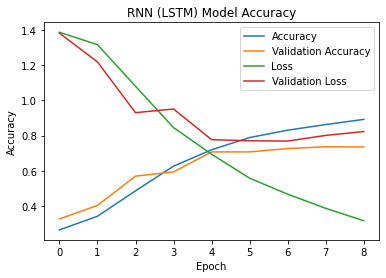

In [10]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history["loss"])
plt.plot(hist.history['val_loss'])
plt.title("RNN (LSTM) Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()
#plt.savefig('rnn_lstm_acc.png')

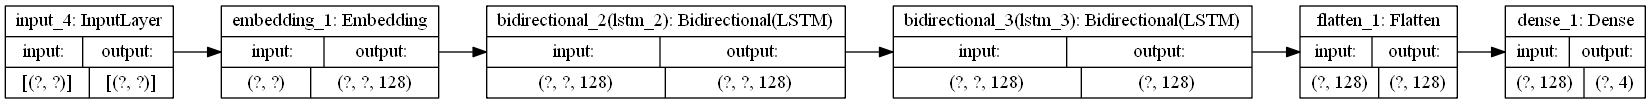

In [15]:
plot_model(lstm_model, rankdir='LR', show_shapes=True)